# Dissertation Notebook
This Jupyter notebook outlines the processes involved in generating synthetic data, applying differential privacy mechanisms, and performing various analytical techniques like clustering and regression. The primary goal is to assess how differential privacy methods impact the analytical utility of data.

## Setup
Step 1: Import Libraries
Here, we import all necessary Python libraries that will be used throughout this notebook. This includes libraries for data manipulation, machine learning, visualization, privacy protection, and more.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from anonymeter.evaluators import SinglingOutEvaluator, LinkabilityEvaluator, InferenceEvaluator
from diffprivlib.mechanisms import Laplace, Gaussian
from faker import Faker
import logging
from scipy.stats import skewnorm
from tqdm.notebook import tqdm
from scipy.stats import entropy

## Data Generation
Function: generate_data(size)

Purpose: Generates a dataset of synthetic individuals, including attributes like name, age, email, salary, etc., using the Faker library.
Process: For each attribute (name, age, email, etc.), a specified number of random values are generated based on defined criteria (e.g., age between 18 and 90). This simulates a real dataset.
Output: Returns a DataFrame with all these attributes.

In [2]:
fake = Faker()

def generate_data(size):
    data = {
        "name": [fake.name() for _ in range(size)],
        "age": [fake.random_int(min=18, max=90) for _ in range(size)],
        "email": [fake.email() for _ in range(size)],
        "salary": [fake.random_int(min=30000, max=150000) for _ in range(size)],
        "hours_per_week": [fake.random_int(min=20, max=60) for _ in range(size)],
        "address": [fake.address() for _ in range(size)]
    }
    return pd.DataFrame(data)

# Create datasets of different sizes
data_small = generate_data(10000)
data_medium = generate_data(50000)
data_large = generate_data(100000)


In [3]:
display(data_small.head())
display(data_medium.head())
display(data_large.head())


,name,age,email,salary,hours_per_week,address
0,Nicolas Romero,54,kmitchell@example.org,75681,44,"03117 Lori Parkway Suite 894\nNew Joanna, IN 7..."
1,Angela Lawrence,55,hrodriguez@example.com,136665,23,"549 Wright Stream Suite 465\nMeyersstad, CT 07533"
2,Melanie Wise,82,mmunoz@example.org,146367,51,"PSC 6448, Box 8159\nAPO AA 03033"
3,Eddie Jones,83,oortiz@example.net,51296,33,"334 Briggs Track Apt. 007\nNorth Barbaramouth,..."
4,Lindsay Davis,60,ericanorton@example.org,58523,30,"7848 Jacqueline Fields\nRobertsburgh, NM 10898"


,name,age,email,salary,hours_per_week,address
0,Gregory Brown,75,gilbertjoshua@example.org,135704,20,"938 Fisher Summit Suite 681\nNorth Robyn, IA 8..."
1,Michael Taylor,69,dudleytimothy@example.com,73670,48,"497 Griffin Turnpike\nSouth Codyport, IA 21077"
2,Michael Spence,21,raytroy@example.org,135611,22,"15739 Kevin Street\nEricashire, TX 06695"
3,Andrew Burch,62,srodriguez@example.com,51988,34,"17039 Melissa Station\nSouth Sheilamouth, OH 6..."
4,Julia Thomas,88,njohnson@example.net,102082,30,"9644 Elizabeth Loop\nNew Stephanie, ME 56622"


,name,age,email,salary,hours_per_week,address
0,Robert Saunders,37,fordheather@example.net,115830,44,40598 Andrew Lakes Apt. 047\nNorth Carriemouth...
1,Megan Mills,47,jamespeterson@example.org,140731,49,"67966 Leah Meadows\nArroyohaven, GU 07968"
2,Toni Harris,88,smithjohn@example.com,99018,39,"625 Stein Unions\nScottside, MD 88739"
3,Timothy Martin,43,larry00@example.org,49915,32,"1312 Carl Cliff Suite 738\nRyanfurt, CT 19770"
4,Dr. Justin Johnston,50,iblair@example.org,51981,58,"42453 Griffin Rapid\nCherryfurt, PR 52810"


## Noise Application Mechanisms
Functions: apply_laplace_mechanism(data, epsilon, sensitivity) and apply_gaussian_mechanism(data, epsilon, delta, sensitivity)

Purpose: Applies differential privacy mechanisms to data. These functions add noise to the data to help preserve individuals' privacy by making it harder to identify original values.
Laplace Mechanism:
Process: Computes a scale based on sensitivity/epsilon and adds Laplace-distributed noise. This noise model is particularly useful when only epsilon privacy is required.
Gaussian Mechanism:
Process: Calculates a sigma based on both epsilon and delta for Gaussian noise, suitable for (epsilon, delta)-differential privacy, offering a stronger privacy guarantee under certain conditions.

In [4]:
def apply_laplace_mechanism(data, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, size=len(data))
    return data + noise

def apply_gaussian_mechanism(data, epsilon, delta, sensitivity):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * (sensitivity / epsilon)
    noise = np.random.normal(0, sigma, size=len(data))
    return data + noise


## Augmenting Data with Noise
Function: apply_noise_mechanisms(dataset, epsilon, delta)

Purpose: Augments a dataset by applying both Laplace and Gaussian noise to the salary field.
Process: Creates new columns in the dataset for the noised data and applies the previously described mechanisms.
Output: The original dataset with additional columns for the noised data.

In [5]:
def apply_noise_mechanisms(dataset, epsilon_values, delta_values):
    results = dataset.copy()
    
    for epsilon in epsilon_values:
        for delta in delta_values:
            # Using standard deviation as sensitivity for demonstration
            sensitivity = dataset['salary'].std()
            
            # Apply Laplace mechanism
            laplace_col = f'laplace_eps_{epsilon}'
            results[laplace_col] = apply_laplace_mechanism(dataset['salary'], epsilon, sensitivity)
        
            # Apply Gaussian mechanism
            gaussian_col = f'gaussian_eps_{epsilon}_delta_{delta}'
            results[gaussian_col] = apply_gaussian_mechanism(dataset['salary'], epsilon, delta, sensitivity)

    return results


In [6]:
epsilon_values = [0.1, 0.25, 0.5, 1, 1.5]
delta = [0.01]  

data_small_noise = apply_noise_mechanisms(data_small, epsilon_values, delta)

data_medium_noise = apply_noise_mechanisms(data_medium, epsilon_values, delta)
data_large_noise = apply_noise_mechanisms(data_large, epsilon_values, delta)

display(data_small_noise.head())
display(data_medium_noise.head())
display(data_large_noise.head())

,name,age,email,salary,hours_per_week,address,laplace_eps_0.1,gaussian_eps_0.1_delta_0.01,laplace_eps_0.25,gaussian_eps_0.25_delta_0.01,laplace_eps_0.5,gaussian_eps_0.5_delta_0.01,laplace_eps_1,gaussian_eps_1_delta_0.01,laplace_eps_1.5,gaussian_eps_1.5_delta_0.01
0,Nicolas Romero,54,kmitchell@example.org,75681,44,"03117 Lori Parkway Suite 894\nNew Joanna, IN 7...",-213710.224615,-606902.915195,167417.642687,4.747316e+05,117906.428690,-70106.353988,86903.448360,-35169.018605,60470.375756,16738.113565
1,Angela Lawrence,55,hrodriguez@example.com,136665,23,"549 Wright Stream Suite 465\nMeyersstad, CT 07533",-341921.138704,-473565.296472,271929.615327,1.071245e+05,221590.201594,216070.590474,54820.399493,97797.515707,143883.453513,129495.963619
2,Melanie Wise,82,mmunoz@example.org,146367,51,"PSC 6448, Box 8159\nAPO AA 03033",304052.015694,-505845.729951,-91003.697627,-5.946291e+05,218684.214485,339147.390412,130476.593288,163058.809230,121989.795564,166111.024256
3,Eddie Jones,83,oortiz@example.net,51296,33,"334 Briggs Track Apt. 007\nNorth Barbaramouth,...",-65295.654038,-9494.046083,-314039.951162,2.722255e+05,53917.579195,-19793.913443,60883.184733,72642.777012,5325.702381,149112.312791
4,Lindsay Davis,60,ericanorton@example.org,58523,30,"7848 Jacqueline Fields\nRobertsburgh, NM 10898",192544.264353,513025.963889,18565.255811,-1.114993e+06,38868.222191,-5274.290137,15012.266327,43977.298933,74613.763535,40467.763207


,name,age,email,salary,hours_per_week,address,laplace_eps_0.1,gaussian_eps_0.1_delta_0.01,laplace_eps_0.25,gaussian_eps_0.25_delta_0.01,laplace_eps_0.5,gaussian_eps_0.5_delta_0.01,laplace_eps_1,gaussian_eps_1_delta_0.01,laplace_eps_1.5,gaussian_eps_1.5_delta_0.01
0,Gregory Brown,75,gilbertjoshua@example.org,135704,20,"938 Fisher Summit Suite 681\nNorth Robyn, IA 8...",213501.173554,1.160501e+06,72062.232114,-678019.079146,215855.430224,36623.587313,154394.989113,57410.299106,156240.034491,92597.656375
1,Michael Taylor,69,dudleytimothy@example.com,73670,48,"497 Griffin Turnpike\nSouth Codyport, IA 21077",-357045.775935,-6.263292e+05,-4083.838448,-35561.515738,163900.751441,103493.730445,-17484.930796,130490.986071,57787.124439,4782.907595
2,Michael Spence,21,raytroy@example.org,135611,22,"15739 Kevin Street\nEricashire, TX 06695",-477352.456322,-8.743669e+05,165841.584376,-294482.974156,157291.869337,305465.578686,84665.140071,49864.191479,134979.551272,116398.025829
3,Andrew Burch,62,srodriguez@example.com,51988,34,"17039 Melissa Station\nSouth Sheilamouth, OH 6...",415256.696915,-6.016468e+05,295972.678858,665786.898697,-109144.459571,-16656.475384,113522.761041,-89328.440923,56369.721178,10481.935055
4,Julia Thomas,88,njohnson@example.net,102082,30,"9644 Elizabeth Loop\nNew Stephanie, ME 56622",-443707.873875,-1.545301e+06,365797.473646,634559.800931,108736.372946,272838.314948,138097.686744,-107357.162144,109182.834451,198768.100909


,name,age,email,salary,hours_per_week,address,laplace_eps_0.1,gaussian_eps_0.1_delta_0.01,laplace_eps_0.25,gaussian_eps_0.25_delta_0.01,laplace_eps_0.5,gaussian_eps_0.5_delta_0.01,laplace_eps_1,gaussian_eps_1_delta_0.01,laplace_eps_1.5,gaussian_eps_1.5_delta_0.01
0,Robert Saunders,37,fordheather@example.net,115830,44,40598 Andrew Lakes Apt. 047\nNorth Carriemouth...,1.762767e+06,1.570861e+06,136054.773306,103660.051169,24304.190212,745603.031544,119883.594979,-145892.322214,123394.840541,140109.314664
1,Megan Mills,47,jamespeterson@example.org,140731,49,"67966 Leah Meadows\nArroyohaven, GU 07968",6.099068e+05,-1.494720e+06,78022.662439,819611.086501,154764.490641,-88887.402892,145836.348317,-21812.981972,143413.606017,188195.864798
2,Toni Harris,88,smithjohn@example.com,99018,39,"625 Stein Unions\nScottside, MD 88739",-6.176931e+05,-5.745329e+05,29621.283786,364114.240941,59171.305990,5913.825930,116224.546690,123345.827087,160026.028097,203329.094200
3,Timothy Martin,43,larry00@example.org,49915,32,"1312 Carl Cliff Suite 738\nRyanfurt, CT 19770",-4.772446e+05,4.603789e+05,45171.464759,515956.442613,171116.831078,44788.553626,-12652.303600,95327.922010,38231.573554,-100195.531385
4,Dr. Justin Johnston,50,iblair@example.org,51981,58,"42453 Griffin Rapid\nCherryfurt, PR 52810",-1.496695e+06,1.460917e+05,499961.383826,163885.002350,178314.597673,44840.376440,94953.256561,-107004.569895,141768.676189,10114.566767


## Visualization of Results
Function: plot_comparisons(data, epsilon, delta, sample_size=None)

Purpose: Visualizes the original and noised salary distributions to compare their density plots.
Process: Samples the data if a sample_size is provided, then uses seaborn to plot KDE (Kernel Density Estimate) plots for original and noised data.


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_comparisons(data, epsilon_values, delta, sample_size=None, save_path=None):
    """
    Plots comparisons of original and noised salary distributions for various levels of differential privacy.
    
    Parameters:
    data (DataFrame): The dataset containing salary and noised salary data.
    epsilon_values (list): List of epsilon values for which noised data is available.
    delta (float): Delta value used in Gaussian noise mechanisms.
    sample_size (int, optional): The number of samples to draw from the data for plotting.
    save_path (str, optional): Path to save the plot images.
    """
    if sample_size:
        data = data.sample(n=sample_size, random_state=1)

    n_epsilons = len(epsilon_values)
    plt.figure(figsize=(n_epsilons * 5, 6))  # Dynamically adjust figure size

    for i, epsilon in enumerate(epsilon_values):
        laplace_col = f'laplace_eps_{epsilon}'
        gaussian_col = f'gaussian_eps_{epsilon}_delta_{delta}'
        
        plt.subplot(1, n_epsilons, i + 1)
        sns.kdeplot(data['salary'], label='Original Salary', color='blue', linestyle='--', linewidth=2)
        
        if laplace_col in data.columns:
            sns.kdeplot(data[laplace_col], label=f'Laplace (ε={epsilon})', color='red')
        else:
            print(f"Column {laplace_col} not found in DataFrame.")
        
        if gaussian_col in data.columns:
            sns.kdeplot(data[gaussian_col], label=f'Gaussian (ε={epsilon}, δ={delta})', color='green')
        else:
            print(f"Column {gaussian_col} not found in DataFrame.")
        
        plt.title(f'Salary Distributions\nε={epsilon}, δ={delta}')
        plt.xlabel('Salary')
        plt.ylabel('Density')
        plt.legend(title='Distributions', loc='upper right')
        plt.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  # Save the figure to the specified path
        plt.close()  # Close the plot to free up memory
    else:
        plt.show()  # Display the plot if no save path is provided

delta = 0.01
epsilon_values = [0.5, 1, 1.5]


# Assuming 'data_small_noise', 'data_medium_noise', and 'data_large_noise' are your DataFrames after noise has been applied
plot_comparisons(data_small_noise, epsilon_values, delta, save_path='/Users/clara/Documents/small_noise_comparisons.png')
plot_comparisons(data_medium_noise, epsilon_values, delta, save_path='/Users/clara/Documents/medium_noise_comparisons.png')
plot_comparisons(data_large_noise, epsilon_values, delta, save_path='/Users/clara/Documents/large_noise_comparisons.png')


In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

def perform_analysis(noised_datasets):
    results = []
    for eps, dataset in noised_datasets.items():
        laplace_col = f'salary_laplace_eps_{eps}'
        if laplace_col in dataset.columns:

            # Prepare the dataset for analysis using RobustScaler
            scaler = RobustScaler()
            scaled_data = scaler.fit_transform(dataset[['age', laplace_col]])
            lr = LinearRegression()
            X = scaled_data[:, 0].reshape(-1, 1)
            y = scaled_data[:, 1]
            lr.fit(X, y)
            mse = mean_squared_error(y, lr.predict(X))
            r2 = r2_score(y, lr.predict(X))

            # Clustering and metrics
            kmeans = KMeans(n_clusters=3, random_state=42)
            clusters = kmeans.fit_predict(scaled_data)
            ch_score = calinski_harabasz_score(scaled_data, clusters)
            db_score = davies_bouldin_score(scaled_data, clusters)
            silhouette = silhouette_score(scaled_data, clusters)

            results.append({
                'Epsilon': eps,
                'MSE': mse,
                'R2 Score': r2,
                'Calinski-Harabasz Score': ch_score,
                'Davies-Bouldin Score': db_score,
                'Silhouette Score': silhouette
            })
        else:
            print(f"Missing data for epsilon: {eps}")
    
    return pd.DataFrame(results)


In [9]:
def create_noised_dataset(data, epsilon_values, delta):
    """Applies Laplace and Gaussian noise mechanisms to the salary column for each epsilon value."""
    datasets = {}
    sensitivity = data['salary'].std()  # Sensitivity as the standard deviation of the salary
    
    for epsilon in epsilon_values:
        temp_data = data.copy()
        laplace_col_name = f'salary_laplace_eps_{epsilon}'
        gaussian_col_name = f'salary_gaussian_eps_{epsilon}_delta_{delta}'
        
        temp_data[laplace_col_name] = apply_laplace_mechanism(data['salary'], epsilon, sensitivity)
        temp_data[gaussian_col_name] = apply_gaussian_mechanism(data['salary'], epsilon, delta, sensitivity)
        
        datasets[epsilon] = temp_data
    
    return datasets


In [12]:
epsilon_values = [0.1, 0.25, 0.5, 1, 1.5]

# Create noised datasets
noised_datasets = create_noised_dataset(data_small, epsilon_values, delta)

# Perform analysis on each dataset and compile results into a DataFrame
analysis_results = perform_analysis(noised_datasets)

# Display the results DataFrame
display(analysis_results)


,Epsilon,MSE,R2 Score,Calinski-Harabasz Score,Davies-Bouldin Score,Silhouette Score
0,0.10,1.066241,0.000117,6300.534053,0.990152,0.358693
1,0.25,1.013557,0.000015,6052.179037,1.024075,0.341040
2,0.50,0.829988,0.000360,5574.407448,1.025059,0.321220
3,1.00,0.634582,0.000034,6074.619326,0.965433,0.341431
4,1.50,0.509628,0.000082,6559.737141,0.909593,0.350594


In [13]:
epsilon_values = [0.1, 0.25, 0.5, 1, 1.5]

# Create noised datasets
noised_medium= create_noised_dataset(data_medium, epsilon_values, delta)

# Perform analysis on each dataset and compile results into a DataFrame
analysis_results2 = perform_analysis(noised_medium)

# Display the results DataFrame
display(analysis_results2)

,Epsilon,MSE,R2 Score,Calinski-Harabasz Score,Davies-Bouldin Score,Silhouette Score
0,0.10,1.013761,2.232529e-06,30635.666927,1.010650,0.345631
1,0.25,0.986482,1.521116e-07,30147.273369,1.027869,0.337026
2,0.50,0.845595,4.481194e-07,27603.473185,1.115458,0.302272
3,1.00,0.618848,5.483555e-05,30352.544532,0.967886,0.339994
4,1.50,0.509309,4.874744e-09,32918.598348,0.919224,0.350640


In [14]:
epsilon_values = [0.1, 0.25, 0.5, 1, 1.5]

# Create noised datasets
noised_large= create_noised_dataset(data_large, epsilon_values, delta)

# Perform analysis on each dataset and compile results into a DataFrame
analysis_results3 = perform_analysis(noised_large)

# Display the results DataFrame
display(analysis_results3)

,Epsilon,MSE,R2 Score,Calinski-Harabasz Score,Davies-Bouldin Score,Silhouette Score
0,0.10,1.025247,3.023918e-06,61887.020365,1.006913,0.348131
1,0.25,0.994596,7.227389e-08,60579.517630,1.021997,0.339468
2,0.50,0.846535,1.682654e-05,56387.098092,1.029802,0.319806
3,1.00,0.614876,4.815716e-05,61038.891884,0.964286,0.340882
4,1.50,0.505654,3.655176e-06,66253.627279,0.912216,0.352203


## Statistical Analysis
Function: compute_statistics(original, noisy)

Purpose: Computes various statistical metrics between original and noised data to assess the impact of the noise.
Metrics:
Mean, Median, Standard Deviation, Mean Squared Error (MSE), and KL Divergence.
KL Divergence: Measures how one probability distribution diverges from a second, expected probability distribution.

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def apply_laplace_mechanism(data, epsilon, sensitivity):
    """Applies Laplace noise to data."""
    noise = np.random.laplace(0, sensitivity / epsilon, size=len(data))
    return data + noise

def apply_gaussian_mechanism(data, epsilon, delta, sensitivity):
    """Applies Gaussian noise to data."""
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    noise = np.random.normal(0, sigma, size=len(data))
    return data + noise

def compute_statistics(original, noisy):
    """Computes statistical measures between original and noisy data."""
    stats = {}
    stats['Mean Original'] = np.mean(original)
    stats['Mean Noisy'] = np.mean(noisy)
    stats['Std Dev Original'] = np.std(original)
    stats['Std Dev Noisy'] = np.std(noisy)
    stats['MSE'] = np.mean((original - noisy) ** 2)
    
    # Calculate the KL divergence if possible
    histogram_original, _ = np.histogram(original, bins=50, range=(min(original), max(original)), density=True)
    histogram_noisy, _ = np.histogram(noisy, bins=50, range=(min(original), max(original)), density=True)
    kl_div = entropy(histogram_noisy, histogram_original)
    stats['KL Divergence'] = kl_div
    
    return stats

def analyze_noised_salaries(data, epsilon_values, delta):
    sensitivity = np.std(data['salary'])  # Assuming standard deviation as sensitivity
    all_stats = []
    
    for epsilon in epsilon_values:
        laplace_noised_salaries = apply_laplace_mechanism(data['salary'], epsilon, sensitivity)
        gaussian_noised_salaries = apply_gaussian_mechanism(data['salary'], epsilon, delta, sensitivity)
        
        laplace_stats = compute_statistics(data['salary'], laplace_noised_salaries)
        gaussian_stats = compute_statistics(data['salary'], gaussian_noised_salaries)
        
        all_stats.append({
            "Epsilon": epsilon,
            "Laplace Mean": laplace_stats['Mean Noisy'],
            "Gaussian Mean": gaussian_stats['Mean Noisy'],
            "Laplace Std Dev": laplace_stats['Std Dev Noisy'],
            "Gaussian Std Dev": gaussian_stats['Std Dev Noisy'],
            "Laplace MSE": laplace_stats['MSE'],
            "Gaussian MSE": gaussian_stats['MSE'],
            "Laplace KL Divergence": laplace_stats['KL Divergence'],
            "Gaussian KL Divergence": gaussian_stats['KL Divergence']
        })

    return pd.DataFrame(all_stats)



results_df = analyze_noised_salaries(data_small, epsilon_values, delta)
display(results_df)


,Epsilon,Laplace Mean,Gaussian Mean,Laplace Std Dev,Gaussian Std Dev,Laplace MSE,Gaussian MSE,Laplace KL Divergence,Gaussian KL Divergence
0,0.10,91333.843057,87313.171302,494107.228624,1.079945e+06,2.430569e+11,1.165473e+12,0.013668,0.059965
1,0.25,89159.903624,88202.964519,200094.626848,4.389867e+05,3.881326e+10,1.912938e+11,0.010478,0.023341
2,0.50,91215.315252,88967.128299,104520.978812,2.219911e+05,9.624333e+09,4.839297e+10,0.009358,0.014091
3,1.00,90552.727506,90159.857369,61578.796118,1.131361e+05,2.446732e+09,1.160827e+10,0.015144,0.009564
4,1.50,90181.553904,88895.360952,47964.843530,7.946455e+04,1.076641e+09,5.090997e+09,0.017687,0.009002


In [18]:
results_df2 = analyze_noised_salaries(data_medium, epsilon_values, delta)
display(results_df2)

,Epsilon,Laplace Mean,Gaussian Mean,Laplace Std Dev,Gaussian Std Dev,Laplace MSE,Gaussian MSE,Laplace KL Divergence,Gaussian KL Divergence
0,0.10,89392.938195,88121.364714,491283.397738,1.076600e+06,2.402873e+11,1.158161e+12,0.005166,0.016309
1,0.25,90255.445497,88912.802656,199900.178867,4.328695e+05,3.870448e+10,1.863727e+11,0.004650,0.004991
2,0.50,90865.236213,90699.889282,104127.871975,2.179418e+05,9.653077e+09,4.625844e+10,0.007314,0.002492
3,1.00,90365.032735,89843.763831,60244.902598,1.127567e+05,2.404547e+09,1.153837e+10,0.011353,0.002910
4,1.50,90052.558449,89995.389552,47805.591310,7.978377e+04,1.082301e+09,5.150764e+09,0.013531,0.005379


In [19]:
results_df3 = analyze_noised_salaries(data_large, epsilon_values, delta)
display(results_df3)

,Epsilon,Laplace Mean,Gaussian Mean,Laplace Std Dev,Gaussian Std Dev,Laplace MSE,Gaussian MSE,Laplace KL Divergence,Gaussian KL Divergence
0,0.10,90867.969596,88596.198248,492977.329404,1.076901e+06,2.417913e+11,1.158671e+12,0.001897,0.006475
1,0.25,89380.800497,91330.580820,197951.378231,4.307211e+05,3.796122e+10,1.844025e+11,0.001793,0.002209
2,0.50,90717.916937,90443.465563,103887.312654,2.179097e+05,9.593708e+09,4.631834e+10,0.005391,0.001500
3,1.00,90044.013140,90147.628663,59715.916314,1.129058e+05,2.393032e+09,1.155037e+10,0.009781,0.001774
4,1.50,90253.251451,90136.218884,47731.946526,7.972842e+04,1.067002e+09,5.149253e+09,0.012521,0.003905


In [16]:
def enhance_statistics_with_original(data, noise_stats):
    """
    Enhances noise statistics with original data statistics for comparison.

    Parameters:
    data (pd.DataFrame): DataFrame containing the original data.
    noise_stats (pd.DataFrame or list of dicts): Statistics from noised data.

    Returns:
    pd.DataFrame: Enhanced DataFrame with both original and noised data statistics.
    """
    # Compute original statistics for comparison
    original_stats = {
        "Mean Original": np.mean(data['salary']),
        "Median Original": np.median(data['salary']),
        "Std Dev Original": np.std(data['salary'])
    }
    
    # Prepare noise_stats if it's a DataFrame
    if isinstance(noise_stats, pd.DataFrame):
        noise_stats = noise_stats.to_dict(orient='records')

    # Update each noise statistic dictionary with original data statistics
    for stat in noise_stats:
        stat.update(original_stats)
    
    # Convert the enhanced results list to a DataFrame for better visualization
    enhanced_results_df = pd.DataFrame(noise_stats)
    return enhanced_results_df

In [17]:
enhanced_results_df = enhance_statistics_with_original(data_small, results_df)
display(enhanced_results_df)

,Epsilon,Laplace Mean,Gaussian Mean,Laplace Std Dev,Gaussian Std Dev,Laplace MSE,Gaussian MSE,Laplace KL Divergence,Gaussian KL Divergence,Mean Original,Median Original,Std Dev Original
0,0.10,91333.843057,87313.171302,494107.228624,1.079945e+06,2.430569e+11,1.165473e+12,0.013668,0.059965,90070.6195,90166.0,34863.081648
1,0.25,89159.903624,88202.964519,200094.626848,4.389867e+05,3.881326e+10,1.912938e+11,0.010478,0.023341,90070.6195,90166.0,34863.081648
2,0.50,91215.315252,88967.128299,104520.978812,2.219911e+05,9.624333e+09,4.839297e+10,0.009358,0.014091,90070.6195,90166.0,34863.081648
3,1.00,90552.727506,90159.857369,61578.796118,1.131361e+05,2.446732e+09,1.160827e+10,0.015144,0.009564,90070.6195,90166.0,34863.081648
4,1.50,90181.553904,88895.360952,47964.843530,7.946455e+04,1.076641e+09,5.090997e+09,0.017687,0.009002,90070.6195,90166.0,34863.081648


In [20]:
enhanced_results_df2 = enhance_statistics_with_original(data_medium, results_df2)
display(enhanced_results_df2)

,Epsilon,Laplace Mean,Gaussian Mean,Laplace Std Dev,Gaussian Std Dev,Laplace MSE,Gaussian MSE,Laplace KL Divergence,Gaussian KL Divergence,Mean Original,Median Original,Std Dev Original
0,0.10,89392.938195,88121.364714,491283.397738,1.076600e+06,2.402873e+11,1.158161e+12,0.005166,0.016309,90155.67702,90337.5,34714.591823
1,0.25,90255.445497,88912.802656,199900.178867,4.328695e+05,3.870448e+10,1.863727e+11,0.004650,0.004991,90155.67702,90337.5,34714.591823
2,0.50,90865.236213,90699.889282,104127.871975,2.179418e+05,9.653077e+09,4.625844e+10,0.007314,0.002492,90155.67702,90337.5,34714.591823
3,1.00,90365.032735,89843.763831,60244.902598,1.127567e+05,2.404547e+09,1.153837e+10,0.011353,0.002910,90155.67702,90337.5,34714.591823
4,1.50,90052.558449,89995.389552,47805.591310,7.978377e+04,1.082301e+09,5.150764e+09,0.013531,0.005379,90155.67702,90337.5,34714.591823


In [21]:
enhanced_results_df3 = enhance_statistics_with_original(data_large, results_df3)
display(enhanced_results_df3)

,Epsilon,Laplace Mean,Gaussian Mean,Laplace Std Dev,Gaussian Std Dev,Laplace MSE,Gaussian MSE,Laplace KL Divergence,Gaussian KL Divergence,Mean Original,Median Original,Std Dev Original
0,0.10,90867.969596,88596.198248,492977.329404,1.076901e+06,2.417913e+11,1.158671e+12,0.001897,0.006475,90259.97776,90460.0,34601.751964
1,0.25,89380.800497,91330.580820,197951.378231,4.307211e+05,3.796122e+10,1.844025e+11,0.001793,0.002209,90259.97776,90460.0,34601.751964
2,0.50,90717.916937,90443.465563,103887.312654,2.179097e+05,9.593708e+09,4.631834e+10,0.005391,0.001500,90259.97776,90460.0,34601.751964
3,1.00,90044.013140,90147.628663,59715.916314,1.129058e+05,2.393032e+09,1.155037e+10,0.009781,0.001774,90259.97776,90460.0,34601.751964
4,1.50,90253.251451,90136.218884,47731.946526,7.972842e+04,1.067002e+09,5.149253e+09,0.012521,0.003905,90259.97776,90460.0,34601.751964


## Full Evaluation
Function: evaluate_noise_impact(data, epsilon, delta)

Purpose: Evaluates the impact of noise by applying mechanisms to the data and computing statistics.
Process: Applies both mechanisms, computes statistics, and formats the results into a DataFrame indexed by epsilon and mechanism type for easy comparison.

## Example of Visualization for Multiple Attributes
Function: visualize_mechanisms(data, epsilon, delta, sensitivity_age, sensitivity_salary)

Purpose: Applies noise mechanisms to both age and salary, then visualizes the results.
Process: Uses histograms and KDE plots to compare the distributions of original and noised data for both attributes.

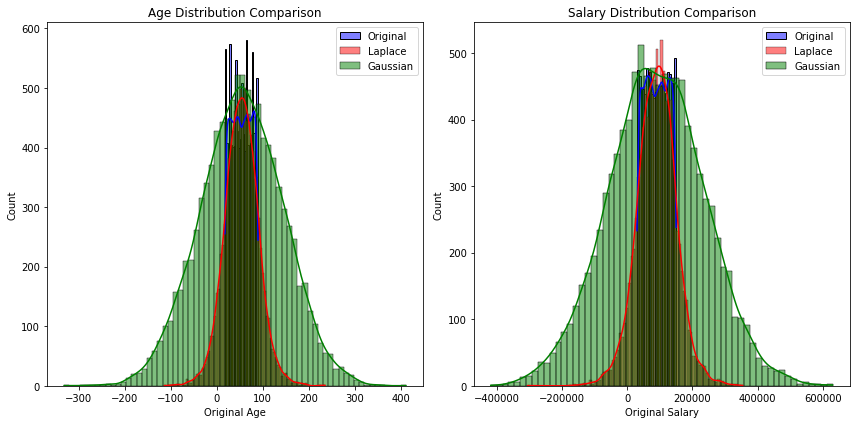

In [22]:
def visualize_mechanisms(data, epsilon, delta, sensitivity_age, sensitivity_salary):
    # Applying Laplace mechanism
    synthetic_age_laplace = apply_laplace_mechanism(data['age'], epsilon, sensitivity_age)
    synthetic_salary_laplace = apply_laplace_mechanism(data['salary'], epsilon, sensitivity_salary)
    
    # Applying Gaussian mechanism
    synthetic_age_gaussian = apply_gaussian_mechanism(data['age'], epsilon, delta, sensitivity_age)
    synthetic_salary_gaussian = apply_gaussian_mechanism(data['salary'], epsilon, delta, sensitivity_salary)
    
    # Creating a DataFrame for visualization
    data_to_plot = pd.DataFrame({
        "Original Age": data['age'],
        "Laplace Age": synthetic_age_laplace,
        "Gaussian Age": synthetic_age_gaussian,
        "Original Salary": data['salary'],
        "Laplace Salary": synthetic_salary_laplace,
        "Gaussian Salary": synthetic_salary_gaussian
    })

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes = axes.flatten()

    # Age comparison plot
    sns.histplot(data_to_plot, x="Original Age", kde=True, color="blue", ax=axes[0], label="Original")
    sns.histplot(data_to_plot, x="Laplace Age", kde=True, color="red", ax=axes[0], label="Laplace")
    sns.histplot(data_to_plot, x="Gaussian Age", kde=True, color="green", ax=axes[0], label="Gaussian")
    axes[0].set_title("Age Distribution Comparison")
    axes[0].legend()

    # Salary comparison plot
    sns.histplot(data_to_plot, x="Original Salary", kde=True, color="blue", ax=axes[1], label="Original")
    sns.histplot(data_to_plot, x="Laplace Salary", kde=True, color="red", ax=axes[1], label="Laplace")
    sns.histplot(data_to_plot, x="Gaussian Salary", kde=True, color="green", ax=axes[1], label="Gaussian")
    axes[1].set_title("Salary Distribution Comparison")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


sensitivity_age = data_small['age'].std()
sensitivity_salary = data_small['salary'].std()
visualize_mechanisms(data_small, epsilon=1, delta=1/(4*1000), sensitivity_age=sensitivity_age, sensitivity_salary=sensitivity_salary)


# Anonymeter evaluation

In [34]:
import pandas as pd

# Generate the control data
data_control = generate_data(10000)
results = []

# Print headers for the privacy risk evaluation
print(f"{'Epsilon':>7} | {'Risk Value':>10} | {'Confidence Interval':>30}")
print("-" * 60)  # This prints a separator line

# Evaluate each dataset in the dictionary
for eps, dataset in noised_datasets.items():
    evaluator = SinglingOutEvaluator(ori=data_small, 
                                     syn=dataset, 
                                     control=data_control,
                                     n_attacks=10)
    try:
        evaluator.evaluate(mode='univariate')
        risk = evaluator.risk(confidence_level=0.95)
        results.append((eps, risk.value, risk.ci))
        print(f"{eps:>7} | {risk.value:>10.3f} | ({risk.ci[0]:.3f}, {risk.ci[1]:.3f})")

        # Immediately retrieve and print the attack results for the current epsilon after evaluation
        print("\nAttack Summary Results for Epsilon", eps, ":")
        print("-" * 30)
        res = evaluator.results()
        print("Success rate of main attack:", res.attack_rate)
        print("Success rate of baseline attack:", res.baseline_rate)
        print("Success rate of control attack:", res.control_rate)

        additional_risk_info = res.risk()  # Retrieve additional risk information
        print("Additional Risk Information:", additional_risk_info)
        print("-" * 30)

    except RuntimeError as ex:
        print(f"{eps:>7} | Evaluation failed: {str(ex)}")
        continue

df_results = pd.DataFrame(results, columns=['Epsilon', 'Risk Value', 'Confidence Interval'])


Found 5 failed queries out of 10. Check DEBUG messages for more details.


Epsilon | Risk Value |            Confidence Interval
------------------------------------------------------------


Found 3 failed queries out of 10. Check DEBUG messages for more details.


    0.1 |      0.839 | (0.676, 1.000)

Attack Summary Results for Epsilon 0.1 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Success rate of control attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Additional Risk Information: PrivacyRisk(value=0.8388748419471806, ci=(0.675671574470861, 1.0))
------------------------------


Found 2 failed queries out of 10. Check DEBUG messages for more details.


   0.25 |      0.839 | (0.676, 1.000)

Attack Summary Results for Epsilon 0.25 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Success rate of control attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Additional Risk Information: PrivacyRisk(value=0.8388748419471806, ci=(0.675671574470861, 1.0))
------------------------------
    0.5 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 0.5 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.2832598399588668, error=0.2265776885044915)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.8241207763533424, ci=(

Found 2 failed queries out of 10. Check DEBUG messages for more details.
Found 2 failed queries out of 10. Check DEBUG messages for more details.
Found 4 failed queries out of 10. Check DEBUG messages for more details.


      1 |      0.671 | (0.403, 0.939)

Attack Summary Results for Epsilon 1 :
------------------------------
Success rate of main attack: SuccessRate(value=0.7167401600411333, error=0.2265776885044915)
Success rate of baseline attack: SuccessRate(value=0.35550655997257785, error=0.24771529256627683)
Success rate of control attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Additional Risk Information: PrivacyRisk(value=0.6710998735577446, ci=(0.40273050334977534, 0.9394692437657138))
------------------------------
    1.5 |      0.839 | (0.676, 1.000)

Attack Summary Results for Epsilon 1.5 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Success rate of control attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Additional Risk Information: PrivacyRisk(value=0.83887484

In [37]:
from anonymeter.evaluators import LinkabilityEvaluator
import pandas as pd

# Define auxiliary columns
aux_cols = [
    ['hours_per_week', 'salary'],
    ['age']
]



results = []

# Loop over different epsilon values
for eps, syn_dataset in noised_datasets.items():
    evaluator = LinkabilityEvaluator(ori=data_small, 
                                     syn=syn_dataset, 
                                     control=data_control,
                                     n_attacks=50,
                                     aux_cols=aux_cols,
                                     n_neighbors=10)

    evaluator.evaluate(n_jobs=-2)  # Use all cores except one
    risk = evaluator.risk()

    # Fetch and print detailed attack results after evaluation
    res = evaluator.results()
    print(f"Epsilon: {eps}")
    print("Success rate of main attack:", res.attack_rate)
    print("Success rate of baseline attack:", res.baseline_rate)
    print("Success rate of control attack:", res.control_rate)

    # Get risk evaluation with different number of neighbors
    risk_with_neighbors = evaluator.risk(n_neighbors=7)
    print("Risk with 7 neighbors:", risk_with_neighbors)

    # Store results in a list for later analysis or export
    results.append({
        'epsilon': eps,
        'risk_value': risk.value,
        'confidence_interval': risk.ci,
        'success_rate_main_attack': res.attack_rate,
        'success_rate_baseline_attack': res.baseline_rate,
        'success_rate_control_attack': res.control_rate,
        'risk_value_7_neighbors': risk_with_neighbors.value,
        'confidence_interval_7_neighbors': risk_with_neighbors.ci
    })

df_results = pd.DataFrame(results)


Epsilon: 0.1
Success rate of main attack: SuccessRate(value=0.10996599163601066, error=0.07841647754741769)
Success rate of baseline attack: SuccessRate(value=0.035673799566679355, error=0.03567379956667936)
Success rate of control attack: SuccessRate(value=0.05424684758401218, error=0.05070758831236596)
Risk with 7 neighbors: PrivacyRisk(value=0.039276735097074265, ci=(0.0, 0.13012816378410638))
Epsilon: 0.25
Success rate of main attack: SuccessRate(value=0.09139294361867784, error=0.07077797326970388)
Success rate of baseline attack: SuccessRate(value=0.035673799566679355, error=0.03567379956667936)
Success rate of control attack: SuccessRate(value=0.035673799566679355, error=0.03567379956667936)
Risk with 7 neighbors: PrivacyRisk(value=0.019260130035860284, ci=(0.0, 0.08314540970956837))
Epsilon: 0.5
Success rate of main attack: SuccessRate(value=0.1471120876706763, error=0.09093608616135357)
Success rate of baseline attack: SuccessRate(value=0.035673799566679355, error=0.0356737995

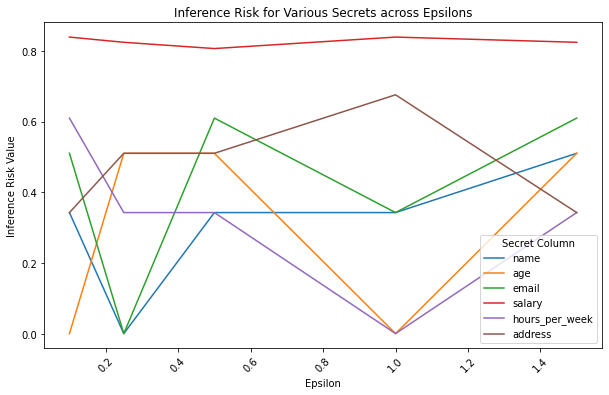

In [40]:
from anonymeter.evaluators import InferenceEvaluator
import pandas as pd
import matplotlib.pyplot as plt

results = []

# Iterate over different epsilons
for eps, syn_dataset in noised_datasets.items():
    # Iterate over each column in the dataset, treating it as an auxiliary attribute
    for secret in data_small.columns:
        aux_cols = [col for col in data_small.columns if col != secret]
        
        evaluator = InferenceEvaluator(ori=data_small, 
                                       syn=syn_dataset, 
                                       control=data_control,
                                       aux_cols=aux_cols,
                                       secret='salary',  # 'salary' is fixed as the secret attribute
                                       n_attacks=10)
        evaluator.evaluate(n_jobs=-2)  # Utilize all cores except one
        
        # Fetch the evaluation results
        eval_results = evaluator.results()
        results.append({
            'epsilon': eps,
            'secret': secret,
            'risk_value': eval_results.risk().value,
            'confidence_interval': eval_results.risk().ci,
            'success_rate_main_attack': eval_results.attack_rate,
            'success_rate_baseline_attack': eval_results.baseline_rate,
            'success_rate_control_attack': eval_results.control_rate
        })

# Convert results to a DataFrame for easier analysis and export
df_results = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(10, 6))
for secret in data_small.columns:
    subset = df_results[df_results['secret'] == secret]
    ax.plot(subset['epsilon'], subset['risk_value'], label=secret)

ax.set_xlabel('Epsilon')
ax.set_ylabel('Inference Risk Value')
ax.set_title('Inference Risk for Various Secrets across Epsilons')
ax.legend(title='Secret Column')
plt.xticks(rotation=45)
plt.show()


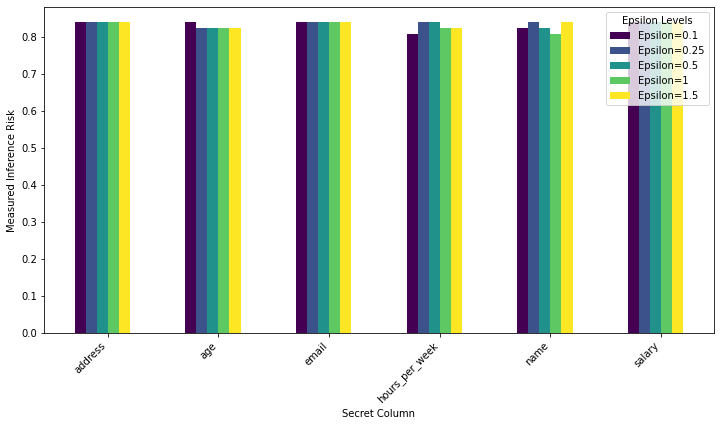

In [42]:
from anonymeter.evaluators import InferenceEvaluator
import pandas as pd
import matplotlib.pyplot as plt

results = []

# Iterate over different epsilons
for eps, syn_dataset in noised_datasets.items():
    # Iterate over each column in the dataset, treating each as a potential secret
    for secret in data_small.columns:
        aux_cols = [col for col in data_small.columns if col != secret]
        
        evaluator = InferenceEvaluator(ori=data_small, 
                                       syn=syn_dataset, 
                                       control=data_control,
                                       aux_cols=aux_cols,
                                       secret=secret,  # Here, each column is treated as the secret in turn
                                       n_attacks=10)
        evaluator.evaluate(n_jobs=-2)  # Utilize all cores except one
        
        # Fetch the evaluation results and append them to results
        eval_results = evaluator.results()
        results.append((eps, secret, eval_results.risk().value))

# Convert the list of tuples to a structured format for easier manipulation
epsilons = sorted(set(res[0] for res in results))  # Unique list of epsilons
columns = sorted(set(res[1] for res in results))  # Unique list of columns

# Setup the figure and axis for plotting
fig, ax = plt.subplots(figsize=(len(columns) * 2, 6))  # Sizing the figure based on the number of columns

# We will use a colormap for different epsilons
colors = plt.cm.viridis(np.linspace(0, 1, len(epsilons)))

# This dictionary will map epsilon to its corresponding color
epsilon_color = dict(zip(epsilons, colors))

# Plot each epsilon's data
for epsilon in epsilons:
    # Extract risks for this epsilon for each column
    eps_risks = [res[2] for res in results if res[0] == epsilon]
    # Get the positions for the bars for this epsilon
    positions = [i + 0.1 * (epsilons.index(epsilon) - len(epsilons)/2) for i in range(len(columns))]

    ax.bar(positions, eps_risks, width=0.1, label=f'Epsilon={epsilon}', color=epsilon_color[epsilon])

# Adjust x-ticks to show column names correctly
ax.set_xticks(range(len(columns)))
ax.set_xticklabels(columns)
plt.xticks(rotation=45, ha='right')

# Adding labels and legend
ax.set_ylabel("Measured Inference Risk")
ax.set_xlabel("Secret Column")
ax.legend(title='Epsilon Levels')

# Show the plot
plt.show()


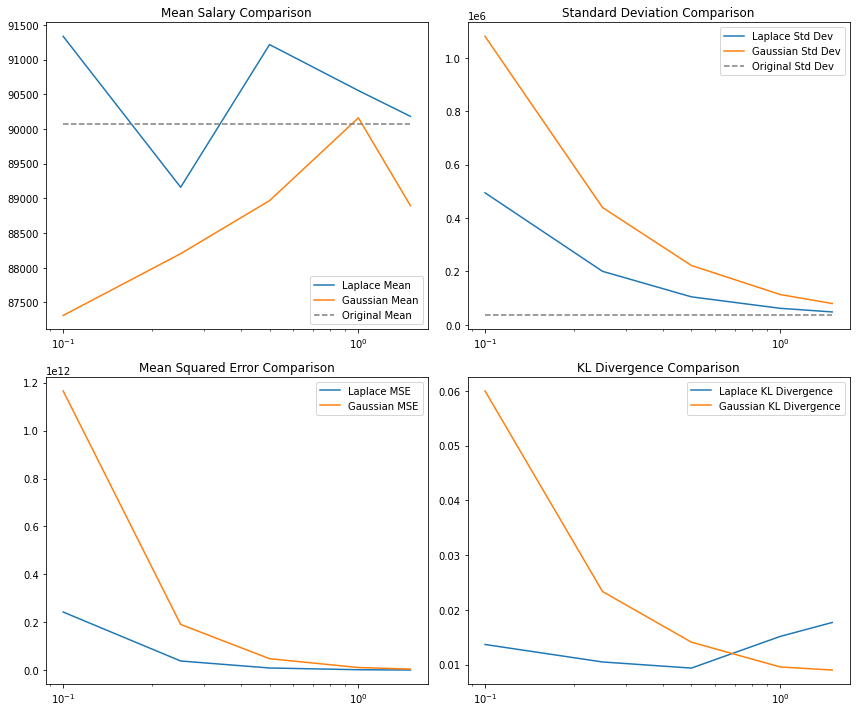

In [43]:
import matplotlib.pyplot as plt

def plot_comparisons(results_df, original_data):
    # Calculate original data statistics
    original_mean = original_data['salary'].mean()
    original_std_dev = original_data['salary'].std()
    original_median = original_data['salary'].median()

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax = ax.ravel()

    # Plot for Mean Comparison
    ax[0].plot(results_df['Epsilon'], results_df['Laplace Mean'], label='Laplace Mean')
    ax[0].plot(results_df['Epsilon'], results_df['Gaussian Mean'], label='Gaussian Mean')
    ax[0].hlines(original_mean, xmin=results_df['Epsilon'].min(), xmax=results_df['Epsilon'].max(), colors='grey', linestyles='dashed', label='Original Mean')
    ax[0].set_xscale('log')
    ax[0].set_title('Mean Salary Comparison')
    ax[0].legend()

    # Plot for Standard Deviation Comparison
    ax[1].plot(results_df['Epsilon'], results_df['Laplace Std Dev'], label='Laplace Std Dev')
    ax[1].plot(results_df['Epsilon'], results_df['Gaussian Std Dev'], label='Gaussian Std Dev')
    ax[1].hlines(original_std_dev, xmin=results_df['Epsilon'].min(), xmax=results_df['Epsilon'].max(), colors='grey', linestyles='dashed', label='Original Std Dev')
    ax[1].set_xscale('log')
    ax[1].set_title('Standard Deviation Comparison')
    ax[1].legend()

    # Plot for Mean Squared Error
    ax[2].plot(results_df['Epsilon'], results_df['Laplace MSE'], label='Laplace MSE')
    ax[2].plot(results_df['Epsilon'], results_df['Gaussian MSE'], label='Gaussian MSE')
    ax[2].set_xscale('log')
    ax[2].set_title('Mean Squared Error Comparison')
    ax[2].legend()

    # Plot for KL Divergence
    ax[3].plot(results_df['Epsilon'], results_df['Laplace KL Divergence'], label='Laplace KL Divergence')
    ax[3].plot(results_df['Epsilon'], results_df['Gaussian KL Divergence'], label='Gaussian KL Divergence')
    ax[3].set_xscale('log')
    ax[3].set_title('KL Divergence Comparison')
    ax[3].legend()

    plt.tight_layout()
    plt.show()

plot_comparisons(results_df, data_small)


In [48]:
import pandas as pd

# Generate the control data
data_control = generate_data(50000)
results2 = []

# Print headers for the privacy risk evaluation
print(f"{'Epsilon':>7} | {'Risk Value':>10} | {'Confidence Interval':>30}")
print("-" * 60)  # This prints a separator line

# Evaluate each dataset in the dictionary
for eps, dataset in noised_medium.items():
    evaluator = SinglingOutEvaluator(ori=data_medium, 
                                     syn=dataset, 
                                     control=data_control,
                                     n_attacks=10)
    try:
        evaluator.evaluate(mode='univariate')
        risk = evaluator.risk(confidence_level=0.95)
        results.append((eps, risk.value, risk.ci))
        print(f"{eps:>7} | {risk.value:>10.3f} | ({risk.ci[0]:.3f}, {risk.ci[1]:.3f})")

        # Immediately retrieve and print the attack results for the current epsilon after evaluation
        print("\nAttack Summary Results for Epsilon", eps, ":")
        print("-" * 30)
        res = evaluator.results()
        print("Success rate of main attack:", res.attack_rate)
        print("Success rate of baseline attack:", res.baseline_rate)
        print("Success rate of control attack:", res.control_rate)

        # Assuming `res.risk()` is a valid method call that returns the actual risk data
        additional_risk_info = res.risk()  # Retrieve additional risk information
        print("Additional Risk Information:", additional_risk_info)
        print("-" * 30)

    except RuntimeError as ex:
        print(f"{eps:>7} | Evaluation failed: {str(ex)}")
        continue

df_results = pd.DataFrame(results2, columns=['Epsilon', 'Risk Value', 'Confidence Interval'])


Epsilon | Risk Value |            Confidence Interval
------------------------------------------------------------


Found 4 failed queries out of 10. Check DEBUG messages for more details.
Found 2 failed queries out of 10. Check DEBUG messages for more details.


    0.1 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 0.1 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.8241207763533424, ci=(0.6430486400312416, 1.0))
------------------------------


Found 4 failed queries out of 10. Check DEBUG messages for more details.


   0.25 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 0.25 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.35550655997257785, error=0.24771529256627683)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.8241207763533424, ci=(0.6430486400312416, 1.0))
------------------------------


Found 5 failed queries out of 10. Check DEBUG messages for more details.


    0.5 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 0.5 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.2832598399588668, error=0.2265776885044915)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.8241207763533424, ci=(0.6430486400312416, 1.0))
------------------------------


Found 3 failed queries out of 10. Check DEBUG messages for more details.
Found 3 failed queries out of 10. Check DEBUG messages for more details.
Found 2 failed queries out of 10. Check DEBUG messages for more details.


      1 |      0.504 | (0.124, 0.884)

Attack Summary Results for Epsilon 1 :
------------------------------
Success rate of main attack: SuccessRate(value=0.6444934400274221, error=0.24771529256627683)
Success rate of baseline attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Success rate of control attack: SuccessRate(value=0.2832598399588668, error=0.2265776885044915)
Additional Risk Information: PrivacyRisk(value=0.5039951996659772, ci=(0.1244762934923429, 0.8835141058396114))
------------------------------
    1.5 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 1.5 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.2832598399588668, error=0.2265776885044915)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.82412077635

In [51]:
from anonymeter.evaluators import LinkabilityEvaluator
import pandas as pd

# Define auxiliary columns
aux_cols = [
    ['hours_per_week', 'salary'],
    ['age']
]



results = []

# Loop over different epsilon values
for eps, syn_dataset in noised_medium.items():
    evaluator = LinkabilityEvaluator(ori=data_medium, 
                                     syn=syn_dataset, 
                                     control=data_control,
                                     n_attacks=100,
                                     aux_cols=aux_cols,
                                     n_neighbors=10)

    evaluator.evaluate(n_jobs=-2)  # Use all cores except one
    risk = evaluator.risk()

    # Fetch and print detailed attack results after evaluation
    res = evaluator.results()
    print(f"Epsilon: {eps}")
    print("Success rate of main attack:", res.attack_rate)
    print("Success rate of baseline attack:", res.baseline_rate)
    print("Success rate of control attack:", res.control_rate)

    # Get risk evaluation with different number of neighbors
    risk_with_neighbors = evaluator.risk(n_neighbors=7)
    print("Risk with 7 neighbors:", risk_with_neighbors)

    # Store results in a list for later analysis or export
    results.append({
        'epsilon': eps,
        'risk_value': risk.value,
        'confidence_interval': risk.ci,
        'success_rate_main_attack': res.attack_rate,
        'success_rate_baseline_attack': res.baseline_rate,
        'success_rate_control_attack': res.control_rate,
        'risk_value_7_neighbors': risk_with_neighbors.value,
        'confidence_interval_7_neighbors': risk_with_neighbors.ci
    })

df_results = pd.DataFrame(results)


Epsilon: 0.1
Success rate of main attack: SuccessRate(value=0.037756879139353126, error=0.03225491158919078)
Success rate of baseline attack: SuccessRate(value=0.01849674910349284, error=0.01849674910349284)
Success rate of control attack: SuccessRate(value=0.028126814121422983, error=0.026359382057282336)
Risk with 7 neighbors: PrivacyRisk(value=0.009908767067407596, ci=(0.0, 0.0526004507815572))
Epsilon: 0.25
Success rate of main attack: SuccessRate(value=0.037756879139353126, error=0.03225491158919078)
Success rate of baseline attack: SuccessRate(value=0.028126814121422983, error=0.026359382057282336)
Success rate of control attack: SuccessRate(value=0.01849674910349284, error=0.01849674910349284)
Risk with 7 neighbors: PrivacyRisk(value=0.009811546736227335, ci=(0.0, 0.042514197036475736))
Epsilon: 0.5
Success rate of main attack: SuccessRate(value=0.057017009175213414, error=0.041353705183665795)
Success rate of baseline attack: SuccessRate(value=0.028126814121422983, error=0.0263

In [52]:
import pandas as pd

# Generate the control data
data_control = generate_data(100000)
results2 = []

# Print headers for the privacy risk evaluation
print(f"{'Epsilon':>7} | {'Risk Value':>10} | {'Confidence Interval':>30}")
print("-" * 60)  # This prints a separator line

# Evaluate each dataset in the dictionary
for eps, dataset in noised_large.items():
    evaluator = SinglingOutEvaluator(ori=data_large, 
                                     syn=dataset, 
                                     control=data_control,
                                     n_attacks=10)
    try:
        evaluator.evaluate(mode='univariate')
        risk = evaluator.risk(confidence_level=0.95)
        results.append((eps, risk.value, risk.ci))
        print(f"{eps:>7} | {risk.value:>10.3f} | ({risk.ci[0]:.3f}, {risk.ci[1]:.3f})")

        # Immediately retrieve and print the attack results for the current epsilon after evaluation
        print("\nAttack Summary Results for Epsilon", eps, ":")
        print("-" * 30)
        res = evaluator.results()
        print("Success rate of main attack:", res.attack_rate)
        print("Success rate of baseline attack:", res.baseline_rate)
        print("Success rate of control attack:", res.control_rate)

        # Assuming `res.risk()` is a valid method call that returns the actual risk data
        additional_risk_info = res.risk()  # Retrieve additional risk information
        print("Additional Risk Information:", additional_risk_info)
        print("-" * 30)

    except RuntimeError as ex:
        print(f"{eps:>7} | Evaluation failed: {str(ex)}")
        continue

df_results = pd.DataFrame(results2, columns=['Epsilon', 'Risk Value', 'Confidence Interval'])


Epsilon | Risk Value |            Confidence Interval
------------------------------------------------------------


Found 4 failed queries out of 10. Check DEBUG messages for more details.


    0.1 |      0.839 | (0.676, 1.000)

Attack Summary Results for Epsilon 0.1 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Success rate of control attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Additional Risk Information: PrivacyRisk(value=0.8388748419471806, ci=(0.675671574470861, 1.0))
------------------------------


Found 4 failed queries out of 10. Check DEBUG messages for more details.


   0.25 |      0.806 | (0.603, 1.000)

Attack Summary Results for Epsilon 0.25 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Success rate of control attack: SuccessRate(value=0.2832598399588668, error=0.2265776885044915)
Additional Risk Information: PrivacyRisk(value=0.8063923194655636, ci=(0.6033410152349548, 1.0))
------------------------------


Found 6 failed queries out of 10. Check DEBUG messages for more details.


    0.5 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 0.5 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.8241207763533424, ci=(0.6430486400312416, 1.0))
------------------------------


Found 4 failed queries out of 10. Check DEBUG messages for more details.
Found 3 failed queries out of 10. Check DEBUG messages for more details.
Found 3 failed queries out of 10. Check DEBUG messages for more details.


      1 |      0.549 | (0.217, 0.882)

Attack Summary Results for Epsilon 1 :
------------------------------
Success rate of main attack: SuccessRate(value=0.6444934400274221, error=0.24771529256627683)
Success rate of baseline attack: SuccessRate(value=0.1387663999314446, error=0.13876639993144463)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.5494138509022283, ci=(0.21663643880416367, 0.8821912630002928))
------------------------------


Found 4 failed queries out of 10. Check DEBUG messages for more details.


    1.5 |      0.824 | (0.643, 1.000)

Attack Summary Results for Epsilon 1.5 :
------------------------------
Success rate of main attack: SuccessRate(value=0.8612336000685554, error=0.13876639993144463)
Success rate of baseline attack: SuccessRate(value=0.2832598399588668, error=0.2265776885044915)
Success rate of control attack: SuccessRate(value=0.21101311994515567, error=0.19313690685008278)
Additional Risk Information: PrivacyRisk(value=0.8241207763533424, ci=(0.6430486400312416, 1.0))
------------------------------


In [54]:
from anonymeter.evaluators import LinkabilityEvaluator
import pandas as pd

# Define auxiliary columns
aux_cols = [
    ['hours_per_week', 'salary'],
    ['age']
]



results = []

# Loop over different epsilon values
for eps, syn_dataset in noised_large.items():
    evaluator = LinkabilityEvaluator(ori=data_large, 
                                     syn=syn_dataset, 
                                     control=data_control,
                                     n_attacks=1000,
                                     aux_cols=aux_cols,
                                     n_neighbors=10)

    evaluator.evaluate(n_jobs=-2)  # Use all cores except one
    risk = evaluator.risk()

    # Fetch and print detailed attack results after evaluation
    res = evaluator.results()
    print(f"Epsilon: {eps}")
    print("Success rate of main attack:", res.attack_rate)
    print("Success rate of baseline attack:", res.baseline_rate)
    print("Success rate of control attack:", res.control_rate)

    # Get risk evaluation with different number of neighbors
    risk_with_neighbors = evaluator.risk(n_neighbors=7)
    print("Risk with 7 neighbors:", risk_with_neighbors)

    # Store results in a list for later analysis or export
    results.append({
        'epsilon': eps,
        'risk_value': risk.value,
        'confidence_interval': risk.ci,
        'success_rate_main_attack': res.attack_rate,
        'success_rate_baseline_attack': res.baseline_rate,
        'success_rate_control_attack': res.control_rate,
        'risk_value_7_neighbors': risk_with_neighbors.value,
        'confidence_interval_7_neighbors': risk_with_neighbors.ci
    })

df_results = pd.DataFrame(results)


Epsilon: 0.1
Success rate of main attack: SuccessRate(value=0.006894245450349786, error=0.004756709923025326)
Success rate of baseline attack: SuccessRate(value=0.0039057257258064515, error=0.0033570821376857243)
Success rate of control attack: SuccessRate(value=0.0039057257258064515, error=0.0033570821376857243)
Risk with 7 neighbors: PrivacyRisk(value=0.0010000792768739774, ci=(0.0, 0.0061495703232228895))
Epsilon: 0.25
Success rate of main attack: SuccessRate(value=0.011875111657922011, error=0.006434357212392761)
Success rate of baseline attack: SuccessRate(value=0.0039057257258064515, error=0.0033570821376857243)
Success rate of control attack: SuccessRate(value=0.0019133792427775617, error=0.0019133792427775617)
Risk with 7 neighbors: PrivacyRisk(value=0.005988497716312482, ci=(0.0004995124015720765, 0.011477483031052888))
Epsilon: 0.5
Success rate of main attack: SuccessRate(value=0.005898072208835341, error=0.004341484068426911)
Success rate of baseline attack: SuccessRate(valu